In [40]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [42]:
def create_dict_of_features():
    """
    Create dictionary with explanation of all attributes.
    
    Return
        dictionary with features from data_description.txt file.
    """
    features = dict()
    with open('./data_description.txt', 'r') as file:
        for line in file.readlines():
            if (line[0] not in [' ', '\t']) and (len(line) > 10):
                line = line.split(':')
                features[line[0]] = line[1].strip('\t\n').lstrip()
        file.close()
    return features

features = create_dict_of_features()

In [43]:
def feature_info(feature_name, plots=True):
    """
    Get an explanation of feature.
    
    Parameters
        feature_name: str
            Name of feature from housing price dataset
        
        plots: bool, default - True
            Draw plots with choosen feature.
    """
    if (feature_name in features.keys()):
        
        feature_type = houses[feature_name].dtype
        
        print(features[feature_name])
        print('   Feature statistics: ')
        
        if feature_type == 'object':
            print(houses[feature_name].describe(include='object'))
        else:
            print(houses[feature_name].describe())
            
            print('\nCorreleation: ')
            print(houses[[feature_name, 'SalePrice']].corr())
    else:
        print('There is no such a feature.')

In [50]:
def check_amount_of_na(ds, percent_of_nan = 40):
    nan = houses.isna().sum() / houses.shape[0] * 100
    return nan[nan > percent_of_nan].sort_values(ascending=False)

In [51]:
def plot_initial_vs_log(df, feature_name):   
    """
    Plots numerical features.
    
    Parameters
        df: pandas DataFrame
            Pandas DataFrame
        
        feature_name: str
            Name of feature for plotting.
    """
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sns.histplot(df[feature_name], ax=ax[0], kde=True)
    ax[0].set_title('original')
    try:
        sns.histplot(df[feature_name].apply(np.log), ax=ax[1], kde=True)
        ax[1].set_title('log')
    except ValueError:
        sns.histplot(df[feature_name].apply(np.sqrt), ax=ax[1], kde=True)
        ax[1].set_title('sqrt')
    plt.tight_layout()
    plt.show();

In [108]:
class TransformDF(BaseEstimator, TransformerMixin):
    """
    Class which implements transformation to housing price dataframe
    """
    
    def __init__(self, fts_40NaN):
        self.fts_40NaN = fts_40NaN
    
    def __fill_na(self, df):
        """
        Fill NaN values in categorical and numerical features

        Parameters
            df: pandas DataFrame
                DataFrame with NaN values

        Return
            None. DataFrame is changing inplace.
        """
        
        # columns with NaN values without featurest that would be deleted
        cls_with_na = set(check_amount_of_na(df, percent_of_nan=0).index).difference(self.fts_40NaN)

        num_cls = df[cls_with_na].select_dtypes(exclude='object').columns
        obj_cls = df[cls_with_na].select_dtypes(include='object').columns

        for clmn in num_cls:
            fill_value = df[clmn].median()
            df[clmn] = df[clmn].fillna(fill_value)
        for clmn in obj_cls:
            fill_value = df[clmn].mode()
            df[clmn] = df[clmn].fillna(fill_value[0])
            
    def __cat_qual_to_num(self, df):
        """
        Converts categorical features of quality to numerical.
        """
        features = ['ExterQual', 'ExterCond', 'BsmtQual',
                    'BsmtCond', 'HeatingQC', 'KitchenQual',
                    'GarageQual', 'GarageCond']
        qual_dict = {'Ex': 5, 'Gd': 4, 'TA': 3,
                     'Fa': 2, 'Po': 1, 'NA': 0}
        for feature in features:
            df[feature] = df[feature].map(qual_dict)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        # delete from dataset attributes with more than 40% of 
        df.drop(self.fts_40NaN, axis=1, inplace=True)
        
        self.__fill_na(df)  # fill NaN values in dataframe
        self.__cat_qual_to_num(df)  # convert categorical features of quality to numerical
        
        return df

In [109]:
class DistributionTransform(BaseEstimator, TransformerMixin):
    """
    Transforms numerical features by square rooting or logarithm.

    Parameters
        log_feat: list, default = None
            List of numerical features, logarithm of which should be taken

        sqrt_feat: list, default = None
            List of numerical features that should be square rooted.
    """
    def __init__(self, num_fts_sqrt, num_fts_log):
        self.fts_sqrt = num_fts_sqrt
        self.fts_log = num_fts_sqrt
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        for column in self.fts_log:
            df[column] = df[column].apply(np.log)
        for column in self.fts_sqrt:
            df[column] = df[column].apply(np.sqrt)
        
        return df

In [110]:
# export train and test datasets
houses = pd.read_csv('./train.csv')
houses_test = pd.read_csv('./test.csv')

In [111]:
X = houses.drop(['Id', 'SalePrice'], axis=1)
y = houses['SalePrice']

X_test = houses_test.drop('Id', axis=1)

In [112]:
check_amount_of_na(X, percent_of_nan=40)

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
FireplaceQu    47.260274
dtype: float64

In [113]:
# lists of features for conversion 
features_40NaN = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
features_to_logarithm = ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']
features_to_sqrt = ['TotalBsmtSF', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF']

In [122]:
init_trans_pipeline = Pipeline([('trans', TransformDF(fts_40NaN=features_40NaN))])

In [123]:
X_tr = init_trans_pipeline.fit_transform(X)

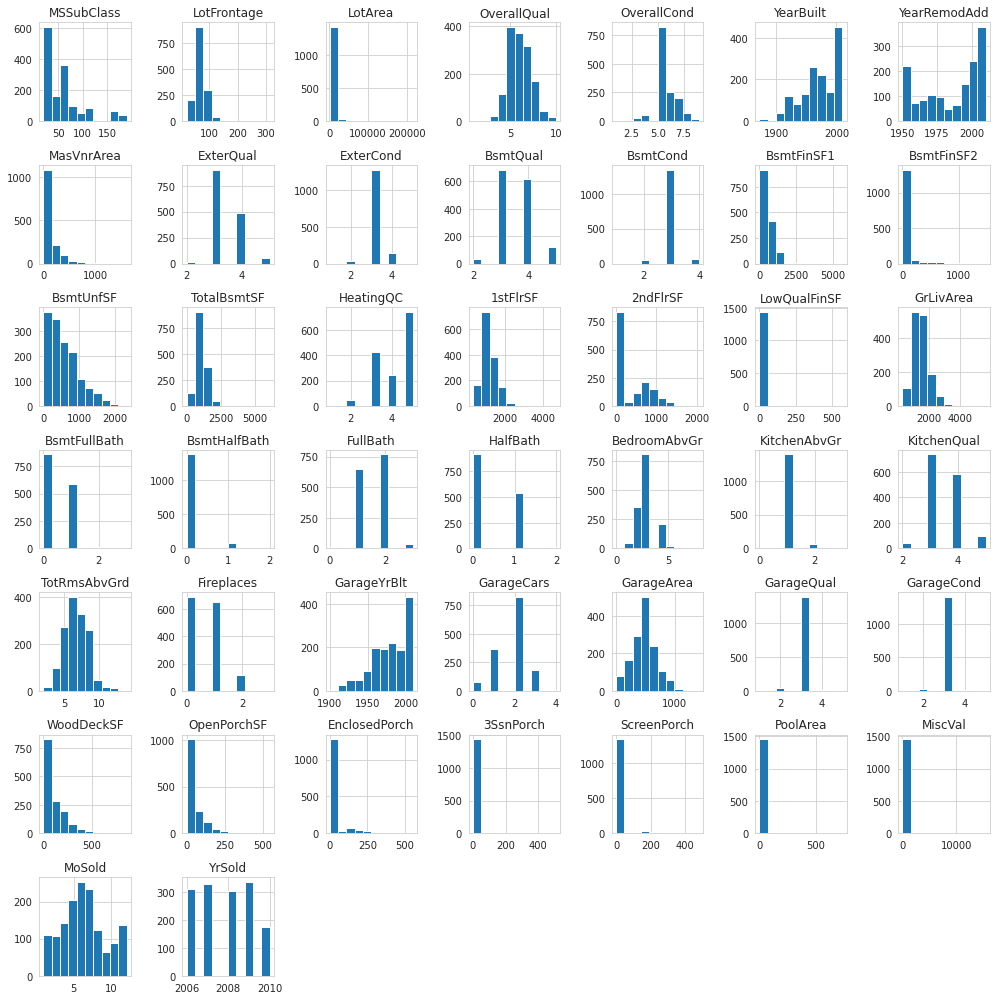

In [125]:
X_tr.hist(figsize=(14, 14));
plt.tight_layout()

In [34]:
def get_ixs(df):
    
    categ_cols = df.columns[df.dtypes == 'object'].tolist()
    categ_cols.append('MSSubClass')
    
    num_cols = df.columns[df.dtypes != 'object'].tolist()

    categ_ixs = [df.columns.get_loc(column) for column in categ_cols]
    num_ixs = [df.columns.get_loc(column) for column in num_cols]
    
    return categ_ixs, num_ixs[1:]  # skip MSSubClass in num